# 0. Disclaimer
The notebook is inspired on the Kaggle competition at https://www.kaggle.com/c/spooky-author-identification, and the notebook shared at https://github.com/ngbolin/SpookyAuthorPy/blob/master/SpookyAuthorPy.ipynb from which repository the raw data are downloaded.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import nltk

In [5]:
import os
from subprocess import Popen, PIPE

def change_folder(path):
    os.chdir(path)

def run_command(command):
    print "\tRunning", command
    p = Popen(command.split(" "), stdout=PIPE, stderr=PIPE)
    output, err = p.communicate(b" ")
    rc = p.returncode
    print "O:", output, "E:", err

# 1. Downloading the Dataset

In [18]:
import requests, zipfile, StringIO
import urllib2

#prefix = "https://www.kaggle.com/c/spooky-author-identification/download/"
#ds = ["sample_submission.zip", "test.zip", "train.zip"]

prefix = "https://raw.githubusercontent.com/ngbolin/SpookyAuthorPy/master/data/"
ds = ["train.csv", "test.csv", "sample_submission.csv"]

#run_command("pwd")
def download_file(prefix, filenames, is_zip=False):
    for fn in ds:
        file_url = os.path.join(prefix, fn)
        if is_zip:
            r = requests.get(file_url, stream=True)
            if r.ok:
                z = zipfile.ZipFile(StringIO.StringIO(r.content))
                z.extractall()
        else:
            run_command("wget "+file_url)

download_file(prefix, ds)
run_command("ls")

	Running wget https://raw.githubusercontent.com/ngbolin/SpookyAuthorPy/master/data/train.csv
O:  E: --2018-05-18 18:49:01--  https://raw.githubusercontent.com/ngbolin/SpookyAuthorPy/master/data/train.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.112.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.112.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3295644 (3.1M) [text/plain]
Saving to: ‘train.csv’

     0K .......... .......... .......... .......... ..........  1%  460K 7s
    50K .......... .......... .......... .......... ..........  3% 1015K 5s
   100K .......... .......... .......... .......... ..........  4% 1.44M 4s
   150K .......... .......... .......... .......... ..........  6% 1.46M 3s
   200K .......... .......... .......... .......... ..........  7% 1.03M 3s
   250K .......... .......... .......... .......... ..........  

# 2. Explorative Analysis

## 2.1 Loading the dataset
- Load test and train and append them into 1 dataframe.
- Explore the unique values for authors

In [177]:
train = pd.read_csv("train.csv")
print "Train len", len(train.index)
test = pd.read_csv("test.csv")
print "Test len", len(test.index)
data = train.append(test)
print "DS len", len(data.index)

print data.head()

print data["author"].value_counts()

Train len 19579
Test len 8392
DS len 27971
  author       id                                               text
0    EAP  id26305  This process, however, afforded me no means of...
1    HPL  id17569  It never once occurred to me that the fumbling...
2    EAP  id11008  In his left hand was a gold snuff box, from wh...
3    MWS  id27763  How lovely is spring As we looked from Windsor...
4    HPL  id12958  Finding nothing else, not even gold, the Super...
EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64


In [178]:
data.groupby('author').describe()

id                       text         \
       count unique      top freq count unique   
author                                           
EAP     7900   7900  id07303    1  7900   7900   
HPL     5635   5635  id16144    1  5635   5635   
MWS     6044   6044  id12000    1  6044   6044   

                                                                
                                                      top freq  
author                                                          
EAP     D rushed to a casement, threw it open, and loo...    1  
HPL     He saw that most of them, in common with their...    1  
MWS     I rode one morning with Raymond to the lofty m...    1

Now let's remove punctuation.

In [194]:
from nltk.corpus import stopwords
import string
#nltk.download('stopwords')
s_words = stopwords.words('english')
    
def remove_stopwords(s_df,
                     column=None,
                     sw=string.punctuation):
    for i in range(len(s_df.index)):
        if column == None:
            # treat it as series
            s_df.iloc[i] = " ".join([token for token in s_df.iloc[i].split() if token.lower() not in sw])
        else:
            # treat it as dataframe
            s_df[column].iloc[i] = " ".join([token for token in s_df[column].iloc[i].split() if token.lower() not in sw])
    return s_df

train = remove_stopwords(train, "text", sw=s_words)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:12: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


## 2.2 Plot a Wordcloud of the documents

(-0.5, 399.5, 199.5, -0.5)

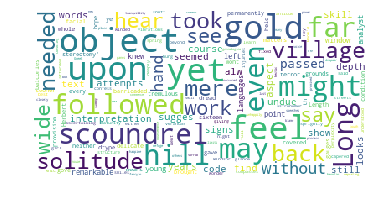

In [145]:
%matplotlib inline

from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white',
                      stopwords=set(s_words),
                      max_words=200,
                      max_font_size=40, 
                      random_state=42
                     ).generate(str(data['text']))
plt.imshow(wordcloud)
plt.axis('off')

Let's print a wordcloud to see if authors tend to use more often certain words

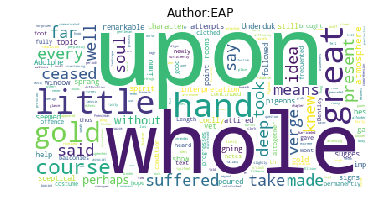

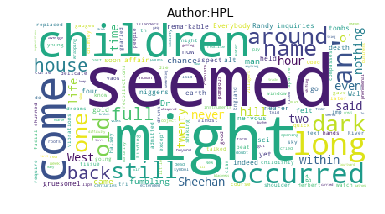

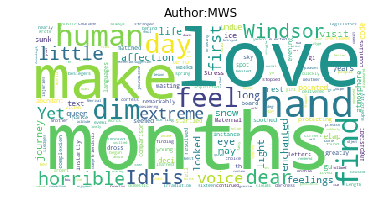

In [167]:
for a in train["author"].unique():
    plt.figure()
    plt.imshow(WordCloud(background_color='white',stopwords=s_words).generate(str(train[train["author"] == a]["text"])))
    plt.title("Author:"+a)
    plt.axis("off")

# 3. Preprocessing

## 3.1 Bag of word modeling
See examples at:
- https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
- http://adataanalyst.com/scikit-learn/countvectorizer-sklearn-example/

In [168]:
from sklearn.feature_extraction.text import CountVectorizer
bagofword_vectorizer = CountVectorizer()
bagofword_vectorizer.fit(train["text"])

#print(vectorizer.vocabulary_)
# encode all documents
text_bow = bagofword_vectorizer.transform(train["text"])

In [169]:
print ('Shape of Sparse Matrix: ', text_bow.shape)
print ('Amount of Non-Zero occurences: ', text_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * text_bow.nnz / (text_bow.shape[0] * text_bow.shape[1])))

('Shape of Sparse Matrix: ', (19579, 25057))
('Amount of Non-Zero occurences: ', 259623)
sparsity: 0.05%


## 3.2 TFIDF: Term Frequency–Inverse Document Frequency
https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [170]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(text_bow)
text_tfidf = tfidf_transformer.transform(text_bow)

# 4. Predicting the Author

To make comparison of methods possible let's split the training set further:

In [205]:
"""
# this will be deprecated from 0.2 version
from sklearn.cross_validation import train_test_split
txt_train, txt_test, label_train, label_test =\
train_test_split(train['text'], train['author'], test_size=0.2)
"""
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train["text"], # X
                                                    train["author"], # Y
                                                    test_size=0.2, # ratio: 80/20
                                                    random_state=42) # random generator seed
print len(X_train)
print len(X_test)
print len(y_train)
print len(y_test)

15663
3916
15663
3916


Let's overwrite the previously computed model to suit the splitted train and test sets:

In [215]:
# X_train
X_train_bow = bagofword_vectorizer.transform(X_train)
print X_train_bow.shape
X_train_tfidf = tfidf_transformer.transform(X_train_bow)
print X_train_tfidf.shape
# X_test
X_test_bow = bagofword_vectorizer.transform(X_test)
print X_test_bow.shape
X_test_tfidf = tfidf_transformer.transform(X_test_bow)
print X_test_tfidf.shape

(15663, 25057)
(15663, 25057)
(3916, 25057)
(3916, 25057)


Let's now import specific libraries to compare the methods

In [216]:
from sklearn.metrics import classification_report

### 4.1 Multinomial Naive Bayes

In [221]:
from sklearn.naive_bayes import MultinomialNB

classification_model = MultinomialNB().fit(X_train_tfidf, y_train)
#print "score:", classification_model.score(X_test_tfidf, y_test)
all_predictions = classification_model.predict(X_test_tfidf)
print classification_report(y_test, all_predictions)

             precision    recall  f1-score   support

        EAP       0.64      0.95      0.77      1570
        HPL       0.95      0.53      0.68      1071
        MWS       0.89      0.69      0.78      1275

avg / total       0.81      0.75      0.75      3916



### 4.2 GradientBoosted Classifier
See explanation at: http://scikit-learn.org/stable/modules/ensemble.html

In [222]:
from sklearn.ensemble import GradientBoostingClassifier
# http://scikit-learn.org/stable/modules/ensemble.html
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0).fit(X_train_tfidf, y_train)
#print "score:", clf.score(X_test_tfidf, y_test)
all_predictions = clf.predict(X_test_tfidf)
print classification_report(y_test, all_predictions)

             precision    recall  f1-score   support

        EAP       0.66      0.81      0.73      1570
        HPL       0.72      0.64      0.68      1071
        MWS       0.76      0.62      0.68      1275

avg / total       0.71      0.70      0.70      3916



# 5. Topic modeling

See https://radimrehurek.com/gensim/tut1.html for further information on topic modeling with gensim.

In [281]:
from gensim import corpora

def get_tokens(df, col, sw):
    # tokenize again all
    return [[token for token in text.lower().split() if token not in sw] for text in df[col]]

def get_dict(tokens):
    return corpora.Dictionary(tokens)

def convert_all_procedural(dictionary, tokens):
    # convertion to bag of words using the dirty (all in memory) API
    return [dictionary.doc2bow(doc_tokens) for doc_tokens in tokens]
    
def convert_all_streaming(dictionary, tokens):
    for line in tokens:
        yield dictionary.doc2bow(line)
        
tks = get_tokens(train, "text", stopwords.words('english'))
d = get_dict(tks)
bow_docs = convert_all_procedural(d, tks)
#bow_docs = convert_all_streaming(d, tks)

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:5: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Transformations can be done directly in gensim using the just extracted bag-of-word dictionary and corpus (i.e., converted td-idf tokens), as explained at https://radimrehurek.com/gensim/tut2.html.

In [284]:
from gensim import corpora, models, similarities
# apply the TfidfModel transformation
tfidf = models.TfidfModel(bow_docs)
# extract a LDA model
model = models.LdaModel(corpus=bow_docs, id2word=d, num_topics=10, passes = 10, random_state=1234)
model.show_topics(num_topics=10)

[(0,
  u'0.008*"upon" + 0.007*"one" + 0.006*"two" + 0.005*"three" + 0.004*"great" + 0.004*"night" + 0.004*"found" + 0.004*"day" + 0.003*"still" + 0.003*"could"'),
 (1,
  u'0.005*"upon" + 0.004*"de" + 0.004*"left" + 0.003*"like" + 0.003*"one" + 0.003*"two" + 0.003*"thrown" + 0.002*"lay" + 0.002*"turned" + 0.002*"side"'),
 (2,
  u'0.004*"made" + 0.003*"feeling" + 0.003*"without" + 0.003*"man" + 0.003*"one" + 0.003*"could" + 0.003*"steps" + 0.003*"even" + 0.003*"found" + 0.002*"thou"'),
 (3,
  u'0.005*"could" + 0.004*"long" + 0.004*"upon" + 0.003*"one" + 0.003*"time" + 0.003*"first" + 0.003*"," + 0.003*"must" + 0.003*"point" + 0.002*"wind"'),
 (4,
  u'0.008*"would" + 0.007*"yet" + 0.007*"upon" + 0.005*"one" + 0.005*"could" + 0.004*"even" + 0.004*"might" + 0.004*"never" + 0.004*"must" + 0.003*"since"'),
 (5,
  u'0.006*"old" + 0.006*"could" + 0.005*"man" + 0.004*"one" + 0.003*"would" + 0.003*"though" + 0.003*"even" + 0.003*"came" + 0.003*"little" + 0.002*"never"'),
 (6,
  u'0.012*"." + 0.00

Alternatively we can extract the LDA model using the structures previously extracted in scikit-learn, using the whole training set in an unsupervised fashion.

In [260]:
from gensim import matutils, models
# Convert sparse matrix to gensim corpus.
corpus = matutils.Sparse2Corpus(text_tfidf, documents_columns=False)
# map ids to actual words as stored in the tfidf model
id_map = dict((v, k) for k, v in bagofword_vectorizer.vocabulary_.items())
ldamodel = models.ldamodel.LdaModel(corpus,
                                    num_topics = 10, # number of latent topics
                                    id2word = id_map,
                                    passes = 10,
                                    random_state = 1234) # seed
ldamodel.show_topics(num_topics=10)

[(0,
  u'0.005*"upon" + 0.004*"could" + 0.004*"would" + 0.004*"one" + 0.003*"it" + 0.003*"said" + 0.003*"us" + 0.003*"time" + 0.003*"much" + 0.003*"me"'),
 (1,
  u'0.003*"smile" + 0.002*"anxious" + 0.002*"understanding" + 0.002*"greatly" + 0.002*"quitted" + 0.002*"endeavoured" + 0.002*"noon" + 0.002*"empty" + 0.002*"loss" + 0.002*"rising"'),
 (2,
  u'0.005*"could" + 0.004*"me" + 0.004*"one" + 0.004*"would" + 0.004*"upon" + 0.003*"yet" + 0.003*"never" + 0.003*"man" + 0.003*"time" + 0.003*"even"'),
 (3,
  u'0.003*"task" + 0.003*"unusual" + 0.003*"had" + 0.003*"own" + 0.003*"original" + 0.002*"shuddered" + 0.002*"st" + 0.002*"weak" + 0.002*"ellison" + 0.002*"paused"'),
 (4,
  u'0.004*"ice" + 0.003*"drawn" + 0.003*"disposition" + 0.003*"move" + 0.002*"placed" + 0.002*"different" + 0.002*"dearest" + 0.002*"farewell" + 0.002*"women" + 0.002*"shook"'),
 (5,
  u'0.002*"characters" + 0.002*"following" + 0.002*"crowded" + 0.002*"wine" + 0.002*"aside" + 0.002*"distinguish" + 0.002*"wealth" + 0.00

The models can be queried to determine the most probable topic given any input text:
1. the text is converted to the TF-IDF format
2. the LDA model is used to determine the probability of belonging to each individual topic

In [300]:
import operator
# function taken from: https://github.com/ngbolin/SpookyAuthorPy/blob/master/SpookyAuthorPy.ipynb
def most_probable_topic(bow_vec, tfidf_tf, text):
    in_bow = bow_vec.transform(text)
    in_tfidf = tfidf_tf.transform(in_bow)
    corpus = matutils.Sparse2Corpus(in_tfidf, documents_columns=False)
    # get probability distribution for each topic
    topic_dist = ldamodel.inference(corpus)[0]
    #for c in topic_dist:
    #    print c, max(enumerate(corpus), key=operator.itemgetter(1))
    topics = [max(enumerate(corpus), key=operator.itemgetter(1))[0] for corpus in topic_dist]
    return topics

most_probable_topic(bagofword_vectorizer, tfidf_transformer, ["the pen is on the table"])

[2]